# Import Libraries

In [20]:
import cv2, keras, os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import segmentation_models as sm
from random import randint
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Data Loading

In [21]:
DATASET = 'dataset/'
x_train = os.path.join(DATASET, 'train')
y_train = os.path.join(DATASET, 'train-mask')
x_val = os.path.join(DATASET, 'val')
y_val = os.path.join(DATASET, 'val-mask')
x_test = os.path.join(DATASET, 'test')
y_test = os.path.join(DATASET, 'test-mask')

# Helper Function for Data Visualization

In [22]:
# Plot images
def visualize(idx, **images):  
    n = len(images)
    if n == 2:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        # Save image to disk
        if ((n == 2) and (name == 'mask')) or ((n == 3) and (name == 'prediction')):
            plt.savefig(name + '_' + str(idx) + '.png', bbox_inches='tight')
    plt.show()

# Dataset and Dataloader Classes

In [23]:
class Dataset:
    CLASSES = ['remote', 'battery']    
    def __init__(self, images_dir, masks_dir, classes=None):
        self.ids = os.listdir(images_dir)
        self.images_ = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_ = [os.path.join(masks_dir, image_id) for image_id in self.ids]        
        # Convert string names to class values
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes] 
    
    def __getitem__(self, i):
        # Read data
        image = cv2.imread(self.images_[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_[i], 0)
        # Extract certain classes from mask (e.g. remotes)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)        
        return image, mask

    def __len__(self):
        return len(self.ids)

class Dataloder(keras.utils.Sequence):       
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset # Instance of Dataset class for image loading
        self.batch_size = batch_size # Number of images in batch
        self.shuffle = shuffle # shuffle image indexes each epoch if True
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    # Collect batch data
    def __getitem__(self, i):        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch

    # Denotes the number of batches per epoch
    def __len__(self):        
        return len(self.indexes) // self.batch_size
    
    # Callback function to shuffle indexes each epoch
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

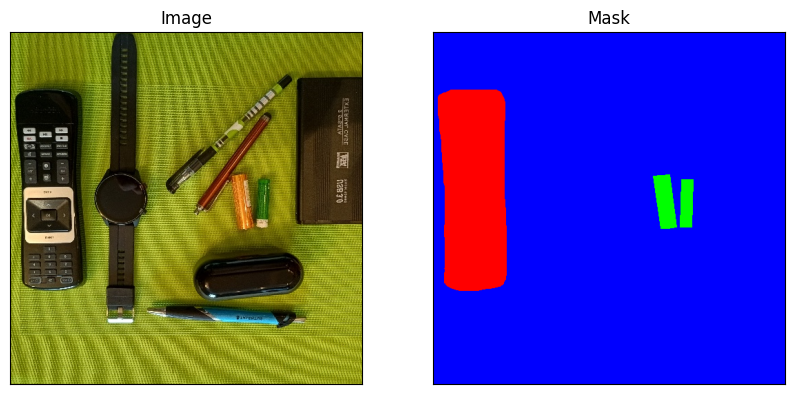

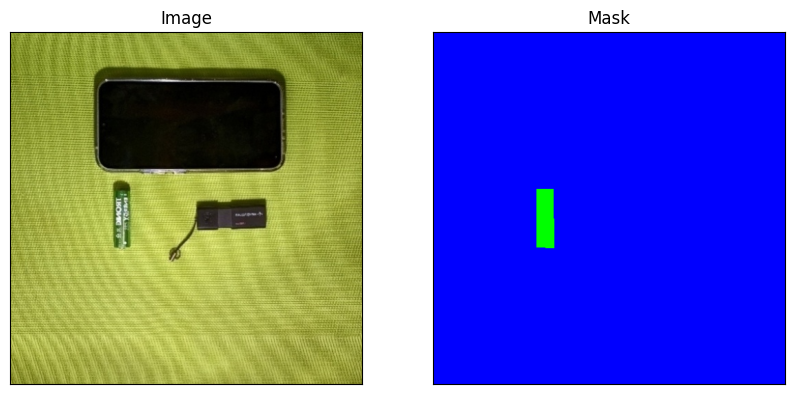

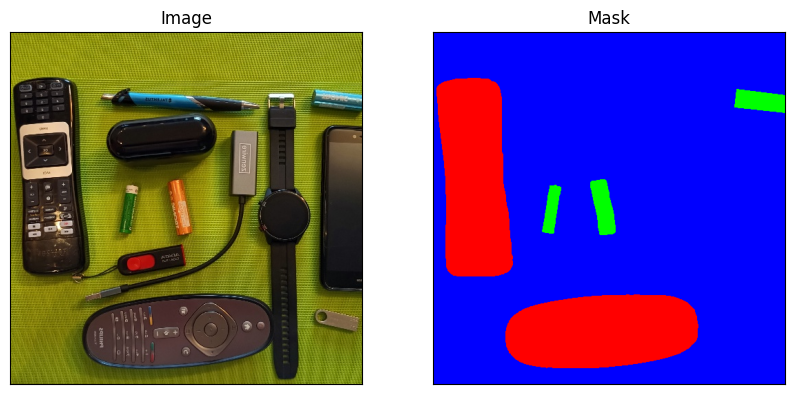

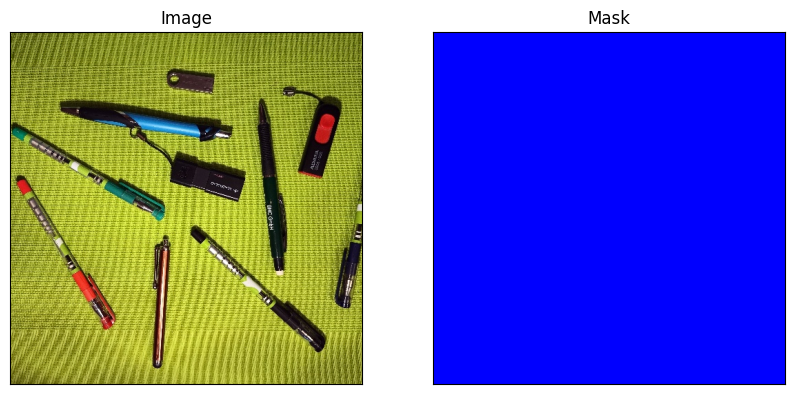

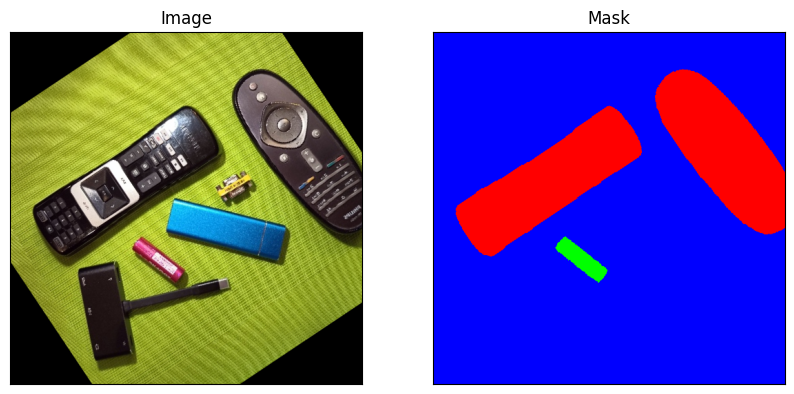

In [24]:
# Example images and masks
dataset = Dataset(x_train, y_train, classes = ['remote', 'battery'])
for i in range(5):
    idx = randint(0, len(dataset))
    image, mask = dataset[idx]            
    # Color choice: remotes - red, batteries - green, background - blue
    temp = (mask[...,0]).copy()
    mask[...,0] = mask[...,2]
    mask[...,2] = temp

    visualize(
        idx,
        image=image,    
        mask=mask.squeeze()    
    )

# Model Training

In [25]:
# Train parameters
BATCH_SIZE = 2
LR = 0.0001
EPOCHS = 30

# Network parameters
CLASSES = ['remote', 'battery']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # Case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
optimizer = keras.optimizers.Adam(LR)
total_loss = sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Create and compile model
BACKBONE = 'efficientnetb3'
sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
model.compile(optimizer, total_loss, metrics)

In [26]:
# Datasets, Dataloaders and Callbacks
train_dataset = Dataset(x_train, y_train, classes=CLASSES)
val_dataset = Dataset(x_val, y_val, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./U-Net_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

In [27]:
# Training
trainingHistory = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

df = pd.DataFrame.from_dict(trainingHistory.history)
df.to_csv('training_history.csv', index = False)

Epoch 1/30
150/150 [==============================] - 70s 365ms/step - loss: 0.9195 - iou_score: 0.3935 - f1-score: 0.4628 - val_loss: 0.7539 - val_iou_score: 0.5455 - val_f1-score: 0.5977 - lr: 1.0000e-04
Epoch 2/30
150/150 [==============================] - 52s 348ms/step - loss: 0.5994 - iou_score: 0.6455 - f1-score: 0.6836 - val_loss: 0.5507 - val_iou_score: 0.8518 - val_f1-score: 0.8794 - lr: 1.0000e-04
Epoch 3/30
150/150 [==============================] - 53s 350ms/step - loss: 0.4453 - iou_score: 0.7263 - f1-score: 0.7489 - val_loss: 0.4347 - val_iou_score: 0.9457 - val_f1-score: 0.9656 - lr: 1.0000e-04
Epoch 4/30
150/150 [==============================] - 53s 351ms/step - loss: 0.3704 - iou_score: 0.7639 - f1-score: 0.7819 - val_loss: 0.3951 - val_iou_score: 0.9555 - val_f1-score: 0.9739 - lr: 1.0000e-04
Epoch 5/30
150/150 [==============================] - 54s 357ms/step - loss: 0.3350 - iou_score: 0.7937 - f1-score: 0.8093 - val_loss: 0.3687 - val_iou_score: 0.9535 - val_f1-s

# Training Results

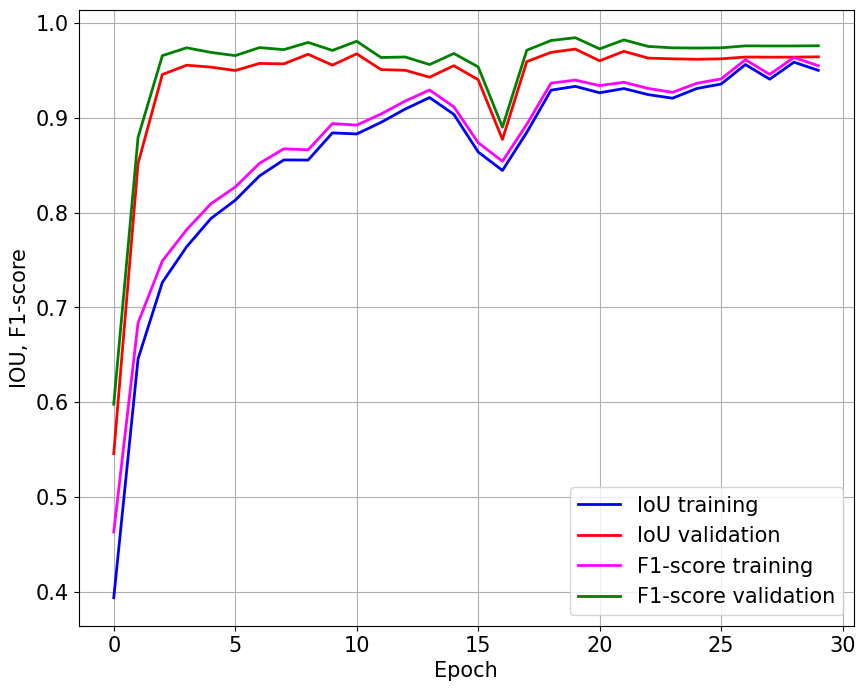

In [28]:
# Loading model weights and training history
model.load_weights('U-Net_model.h5')
df = pd.read_csv('training_history.csv', sep = ',')
train_iou = df['iou_score']
val_iou = df['val_iou_score']
train_f1 = df['f1-score']
val_f1 = df['val_f1-score']

# Plots
epochs = range(len(train_iou))
plt.figure(1, figsize=(10, 8))
plt.plot(epochs, train_iou, color='blue', label='IoU training', linewidth=2)
plt.plot(epochs, val_iou, color='red', label='IoU validation', linewidth=2)    
plt.plot(epochs, train_f1, color='magenta', label='F1-score training', linewidth=2)
plt.plot(epochs, val_f1, color='green', label='F1-score validation', linewidth=2)  
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('IOU, F1-score', fontsize=15)
plt.legend(loc='lower right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()  

# Evaluation

In [29]:
test_dataset = Dataset(x_test, y_test, classes=CLASSES)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
scores = model.evaluate(test_dataloader)

# Evaluation metrics
for metric, value in zip(metrics, scores[1:]):
    print('Mean {}: {:.5}'.format(metric.__name__, value))
print('Loss: {:.5}'.format(scores[0]))

150/150 [==============================] - 8s 51ms/step - loss: 0.3145 - iou_score: 0.9646 - f1-score: 0.9772
Mean iou_score: 0.96461
Mean f1-score: 0.97718
Loss: 0.31451


1/1 [==============================] - 0s 108ms/step


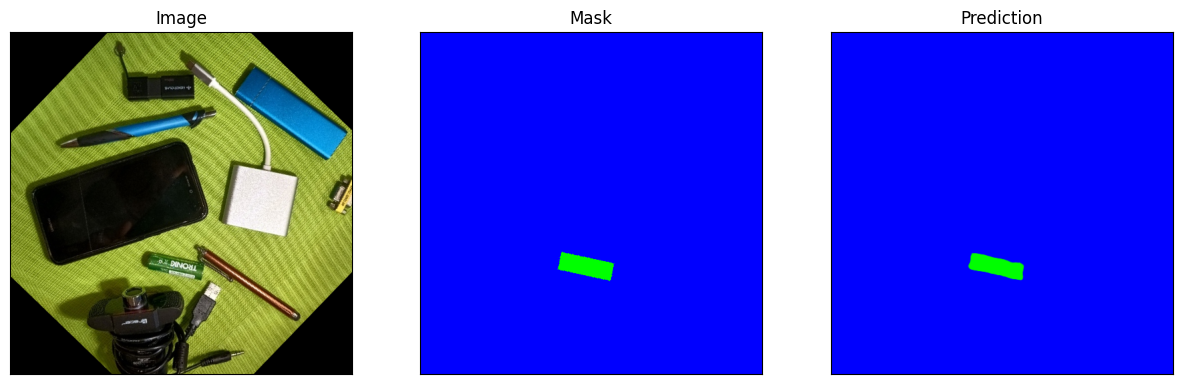

1/1 [==============================] - 0s 120ms/step


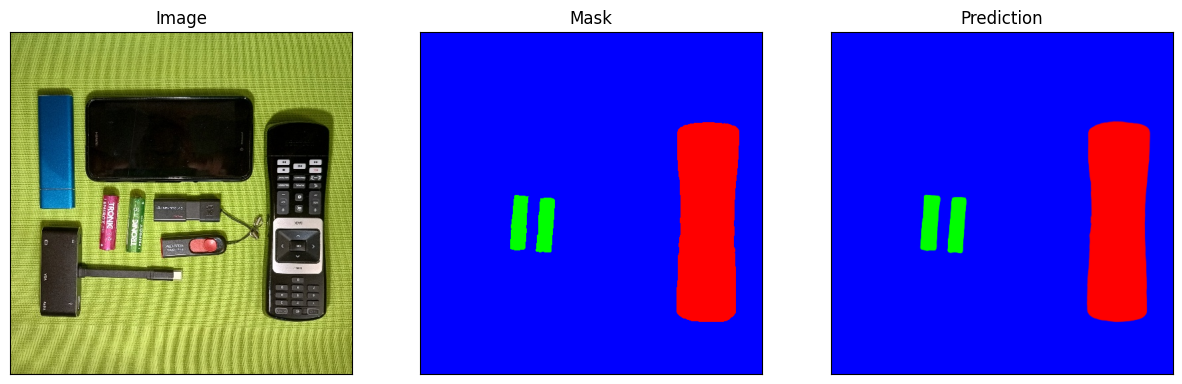

1/1 [==============================] - 0s 100ms/step


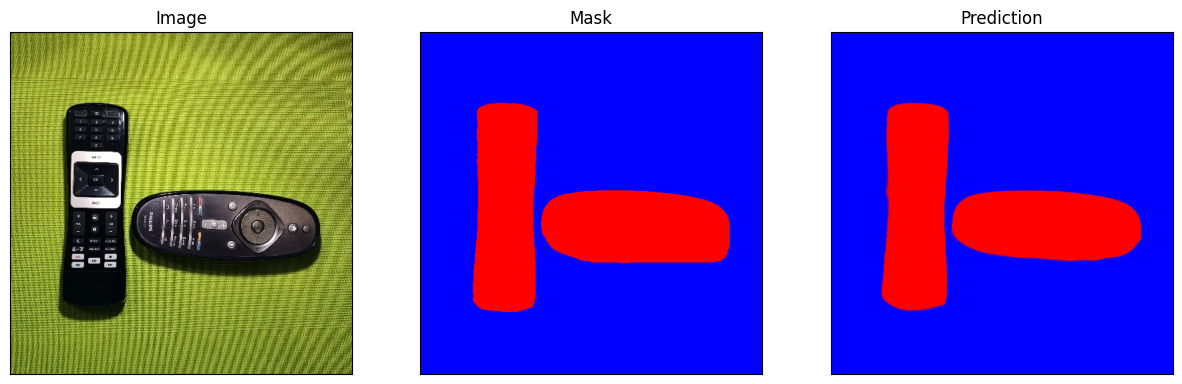

1/1 [==============================] - 0s 93ms/step


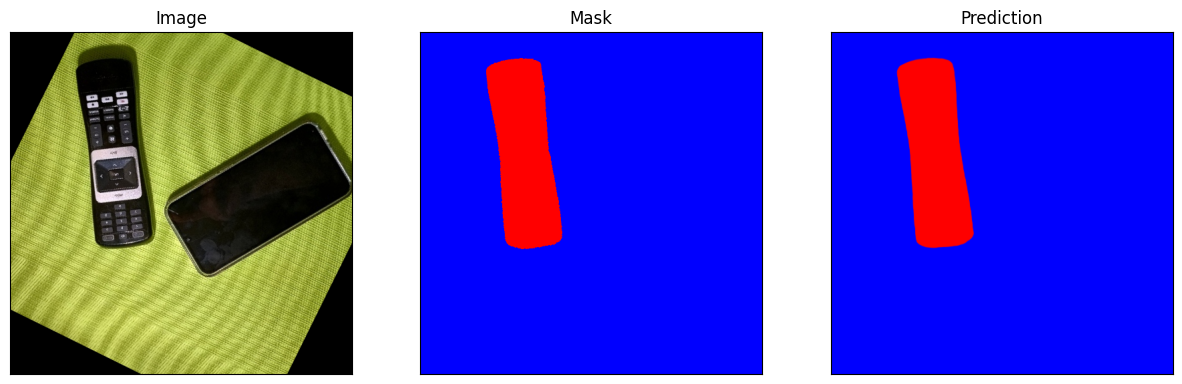

1/1 [==============================] - 0s 106ms/step


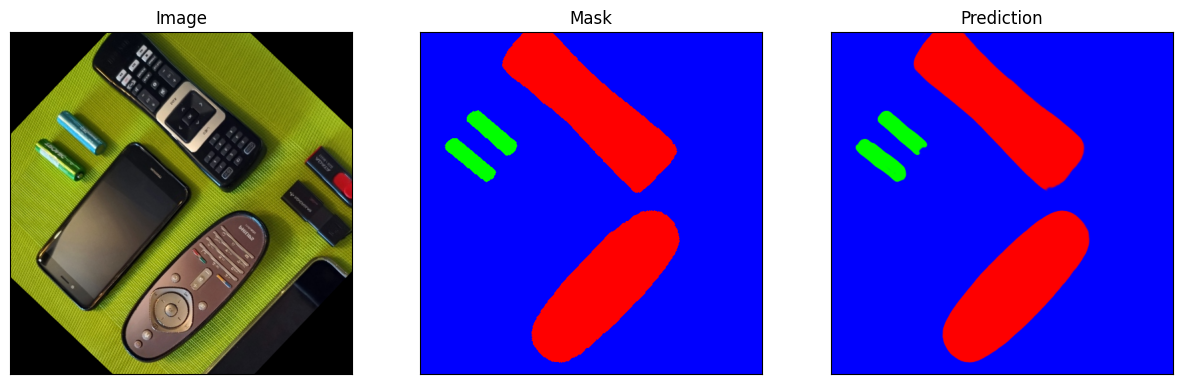

In [32]:
# Example images, masks and segmentation results
for i in range(5):
    idx = randint(0, len(test_dataset))
    image, mask = test_dataset[idx]
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)

    # Color choice: remotes - red, batteries - green, background - blue
    temp = (mask[...,0]).copy()
    mask[...,0] = mask[...,2]
    mask[...,2] = temp
    temp = (prediction[...,0]).copy()
    prediction[...,0] = prediction[...,2]
    prediction[...,2] = temp

    visualize(
        idx,
        image=image.squeeze(),
        mask = mask.squeeze(),
        prediction = prediction.squeeze()
    )